# FDL 2019 - Floods

Load in any libraries and datasets needed

In [1]:
gp:.p.import[`geopandas]
\l ml/ml.q 
\l ml/init.q
\l ml/fresh/notebooks/graphics.q

avs:.p.import[`sklearn.metrics]`:average_precision_score
mattab:{flip value flip x}
svc:.p.import[`sklearn.svm]`:SVC
array:.p.import[`numpy]`:array

Datasets include

Max height per day per stream

NLCD(imperveous) dataset collected in 2006,2011,2016

Flood warned levels from NOAA, based on lat,long

stream gage info i.e location,state, codes etc

basin attributes at each stream gage

In [2]:
nlcd06:("S",(5#"F"),"SFFSFSFFFFSFSSFSSFFFSFFSFF";enlist ",") 0:`:data/snap_sampled_imp_nlcd_2006.csv 
nlcd11:("S",(5#"F"),"SFFSFSFFFFSFSSFSSFFFSFFSFF";enlist ",") 0:`:data/snap_sampled_imp_nlcd_2011.csv 
nlcd16:("S",(5#"F"),"SFFSFSFFFFSFSSFSSFFFSFFSFF";enlist ",") 0:`:data/snap_sampled_imp_nlcd_2016.csv 

warnings:gp[`:read_file]["data/national_shapefile_obs.shp"]
warnings:.ml.df2tab[warnings]

gages:("SSSSFFSSIFFFFFFFFSSISSSSFF";enlist ",") 0:`:data/usgs_gage_subset.csv

basin:("S",242#"F";enlist ",") 0:`:data/gages_with_basin_attr.csv

Linking the stream gages with corresponding rain gages based on site_no and date (per month). 

In [3]:
\l gagesdir/gagesdir  /will change name of loaddir

maxht:0!select max height by site_no,date from str

maxht[`site_no]:`${$[7=count x;"0",x;x]}each maxht[`site_no]

maxht:delete from maxht where height<0

gages[`site_no]:`${$[7=count x;"0",x;x]}each string each gages[`site_no] /pad with 0 if len site=7


In [4]:
\cd ../../

Get the rain data from prism

In [5]:
show precipall:raze {flip `site_no`long`lat`elv`date`ppt!flip value each 10_("SFFFDF";enlist ",")0: 
    hsym `$"data/prism/",string[x]} each key `:data/prism

precipall[`site_no]:`${$[7=count x;"0",x;x]}each string each precipall[`site_no]


site_no long     lat     elv  date       ppt 
---------------------------------------------
1367690 -74.5596 41.1053 1056 2019.01.01 0.94
1367690 -74.5596 41.1053 1056 2019.01.02 0   
1367690 -74.5596 41.1053 1056 2019.01.03 0   
1367690 -74.5596 41.1053 1056 2019.01.04 0   
1367690 -74.5596 41.1053 1056 2019.01.05 0.38
1367690 -74.5596 41.1053 1056 2019.01.06 0.79
1367690 -74.5596 41.1053 1056 2019.01.07 0   
1367690 -74.5596 41.1053 1056 2019.01.08 0.02
1367690 -74.5596 41.1053 1056 2019.01.09 0.15
1367690 -74.5596 41.1053 1056 2019.01.10 0   
1367690 -74.5596 41.1053 1056 2019.01.11 0   
1367690 -74.5596 41.1053 1056 2019.01.12 0   
1367690 -74.5596 41.1053 1056 2019.01.13 0   
1367690 -74.5596 41.1053 1056 2019.01.14 0   
1367690 -74.5596 41.1053 1056 2019.01.15 0   
1367690 -74.5596 41.1053 1056 2019.01.16 0   
1367690 -74.5596 41.1053 1056 2019.01.17 0   
1367690 -74.5596 41.1053 1056 2019.01.18 0.06
1367690 -74.5596 41.1053 1056 2019.01.19 0   
1367690 -74.5596 41.1053 1056 2019

Some rain sites are missing the last digits of their id number so have to preprocess to get it to match the stream gages

In [6]:
rms:asc ds where 12<count each string each ds:exec distinct site_no from gages 
names:0!select i by site_no from precipall where site_no in `$12#'string each rms

{![`precipall;enlist (in;`i;y);0b;(enlist `site_no)!enlist enlist x]}'[rms[til[20],23 24 25];
    names[`x][til[19],21 22 23 24]]

matchnames:0!select i by lat,long from precipall where i in names[`x][20]
{![`precipall;enlist (in;`i;y);0b;(enlist `site_no)!enlist enlist x]}'[rms[21 22];matchnames[`x]]

`precipall`precipall`precipall`precipall`precipall`precipall`precipall`precip..


`precipall`precipall


Get stats on each rain gage per month,uid (id of raingage)

In [7]:
show rainmonth:1_0!select first distinct lat,first distinct long,elevation:distinct elv,sumpr:sum ppt,
    maxpre:max ppt,avgpre:avg ppt,varpre:var ppt by site_no
    ,"m"$date from precipall

site_no  date    lat     long     elevation sumpr maxpre avgpre     varpre    
------------------------------------------------------------------------------
01200000 2009.07 41.6588 -73.5287 456       8.01  2.04   0.2583871  0.2031039 
01200000 2009.08 41.6588 -73.5287 456       5.94  1.59   0.1916129  0.1258458 
01200000 2009.09 41.6588 -73.5287 456       1.55  0.85   0.05166667 0.02672056
01200000 2009.10 41.6588 -73.5287 456       4.51  1.46   0.1454839  0.1004828 
01200000 2009.11 41.6588 -73.5287 456       1.52  0.49   0.05066667 0.01351289
01200000 2009.12 41.6588 -73.5287 456       5.61  0.93   0.1809677  0.08818939
01200000 2010.01 41.6588 -73.5287 456       2.82  1.75   0.09096774 0.0974539 
01200000 2010.02 41.6588 -73.5287 456       4.41  2.28   0.1575     0.1941045 
01200000 2010.03 41.6588 -73.5287 456       6.5   1.36   0.2096774  0.1715322 
01200000 2010.04 41.6588 -73.5287 456       2.17  0.57   0.07233333 0.01860456
01200000 2010.05 41.6588 -73.5287 456       1.93  0.

### Basin Characteristics

Take out columns that depend on the date like 09,10,11. Link it with previous table

In [8]:
cols09:where (count each ss[;"2006"]each string each cols basin)<>0
cols10:where (count each ss[;"2010"]each string each cols basin)<>0
cols11:where (count each ss[;"2011"]each string each cols basin)<>0

In [9]:
constcols:(til count[cols basin]) except raze 
    {where (count each ss[;x]each string each cols basin)<>0}each ("2009";"2010";"2011")

basinupd:flip (cols basin)[constcols]!basin[(cols basin)[constcols]]

show joinedtab:rainmonth ij `site_no xkey basinupd

site_no  date    lat     long     elevation sumpr maxpre avgpre     varpre   ..
-----------------------------------------------------------------------------..
01200000 2009.07 41.6588 -73.5287 456       8.01  2.04   0.2583871  0.2031039..
01200000 2009.08 41.6588 -73.5287 456       5.94  1.59   0.1916129  0.1258458..
01200000 2009.09 41.6588 -73.5287 456       1.55  0.85   0.05166667 0.0267205..
01200000 2009.10 41.6588 -73.5287 456       4.51  1.46   0.1454839  0.1004828..
01200000 2009.11 41.6588 -73.5287 456       1.52  0.49   0.05066667 0.0135128..
01200000 2009.12 41.6588 -73.5287 456       5.61  0.93   0.1809677  0.0881893..
01200000 2010.01 41.6588 -73.5287 456       2.82  1.75   0.09096774 0.0974539..
01200000 2010.02 41.6588 -73.5287 456       4.41  2.28   0.1575     0.1941045..
01200000 2010.03 41.6588 -73.5287 456       6.5   1.36   0.2096774  0.1715322..
01200000 2010.04 41.6588 -73.5287 456       2.17  0.57   0.07233333 0.0186045..
01200000 2010.05 41.6588 -73.5287 456   

### NLCD Dataset

Join NLCD (impervious info) to each station based on date. Only 3 datasets so link back in time

Only pick columns with some variance between stations

In [10]:
nlcd06:update site_no:`${$[7=count x;"0",x;x]}each string each site_no,year:6 from select
 site_no:SOURCE_FEA,INTPTLAT,INTPTLON,Measure,REACHCODE,distance,imp:imp_nlcd_2006 from nlcd06
nlcd11:update site_no:`${$[7=count x;"0",x;x]}each string each site_no,year:11 from select
 site_no:SOURCE_FEA,INTPTLAT,INTPTLON,Measure,REACHCODE,distance,imp:imp_nlcd_2011 from nlcd11
nlcd16:update site_no:`${$[7=count x;"0",x;x]}each string each site_no,year:16 from select
 site_no:SOURCE_FEA,INTPTLAT,INTPTLON,Measure,REACHCODE,distance,imp:imp_nlcd_2016 from nlcd16

In [11]:
stryear:{$[x<2011;6;x<2016;11;16]}each `year$joinedtab[`date]

merged:update year:stryear from joinedtab

newjoinedtab:merged ij `site_no xkey (nlcd06,nlcd11,nlcd16)

# Getting the Target Data

Get the count per month that a station goes over a flood level, broken up into 4 categories-Action,Flood,Moderate and Major

In [12]:
/Some gages have no threshold values so had to delete them from dataset
dela:first asc exec i by Action from warnings
delmj:first 1_asc exec i by Major from warnings
delmd:first 2_asc exec i by Moderate from warnings
delfl:first 2_asc exec i by Flood from warnings

warning:update nn: i from select from warnings where not i in distinct (dela,delmj,delmd,delfl)

Join based on nn

In [26]:
tabw:.ml.clust.kd.buildtree[warnlatl:raze each warning[`Latitude`Longitude],'gages[`dec_lat_va`dec_long_v];2]

nnwarn:.ml.clust.kd.i.nns[;tabw;(count[warning]#0),count[gages]#1;flip warnlatl;`edist
    ]each count[warning]+til count gages

In [27]:
joins:flip `nn`ndw`site_no!(nnwarn[;0];nnwarn[;1];gages[`site_no])

floodlvl:(maxht ij `site_no xkey joins) lj `nn xkey warning

floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

floodlvl[`site_no]:`${$[7=count x;"0",x;x]}each string each floodlvl[`site_no] /pad with 0 if len site=7

In [28]:
show target:0!select distinct Action,distinct Flood,distinct Moderate,distinct Major,no_Action:count where 
 height>Action,no_Flood:count where height>Flood,no_Mod:count where height>Moderate,no_Major:count where 
 height>Major by site_no,"m"$date from floodlvl where ndw<0.3

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 6      9     10       12    0         0        0      0       
01200000 2009.08 6      9     10       12    0         0        0      0       
01200000 2009.09 6      9     10       12    0         0        0      0       
01200000 2009.10 6      9     10       12    0         0        0      0       
01200000 2009.11 6      9     10       12    0         0        0      0       
01200000 2009.12 6      9     10       12    0         0        0      0       
01200000 2010.01 6      9     10       12    0         0        0      0       
01200000 2010.02 6      9     10       12    0         0        0      0       
01200000 2010.03 6      9     10       12    1         0        0      0       
01200000 2010.04 6      9     10       12    0         0        0      0       
01200000 2010.05 6      9     10       1

In [29]:
show allmerged:newjoinedtab ij `site_no`date xkey target


site_no  date    lat     long     elevation sumpr maxpre avgpre     varpre   ..
-----------------------------------------------------------------------------..
01200000 2009.07 41.6588 -73.5287 456       8.01  2.04   0.2583871  0.2031039..
01200000 2009.08 41.6588 -73.5287 456       5.94  1.59   0.1916129  0.1258458..
01200000 2009.09 41.6588 -73.5287 456       1.55  0.85   0.05166667 0.0267205..
01200000 2009.10 41.6588 -73.5287 456       4.51  1.46   0.1454839  0.1004828..
01200000 2009.11 41.6588 -73.5287 456       1.52  0.49   0.05066667 0.0135128..
01200000 2009.12 41.6588 -73.5287 456       5.61  0.93   0.1809677  0.0881893..
01200000 2010.01 41.6588 -73.5287 456       2.82  1.75   0.09096774 0.0974539..
01200000 2010.02 41.6588 -73.5287 456       4.41  2.28   0.1575     0.1941045..
01200000 2010.03 41.6588 -73.5287 456       6.5   1.36   0.2096774  0.1715322..
01200000 2010.04 41.6588 -73.5287 456       2.17  0.57   0.07233333 0.0186045..
01200000 2010.05 41.6588 -73.5287 456   

In [30]:
/Tidy up some column types
allmerged[`lat`long]:raze each "F"$'string each allmerged[`lat`long]
allmerged[`Action]:raze allmerged[`Action]
allmerged[`Flood]:raze allmerged[`Flood]
allmerged[`Moderate]:raze allmerged[`Moderate]
allmerged[`Major]:raze allmerged[`Major]
allmerged[`elevation]:raze allmerged[`elevation]

/add cosin of month
allmerged:update month:`mm$date,cos_t:cos 2*3.14*(`mm$date)%12,sin_t:sin 2*3.14*(`mm$date)%12 from allmerged

### Adding Features Columns

Add lagged features. Previous data about rainfall/stream gages are also an important feature needed to measure if a river will flood or not. The lagged stream features that will be extracted are:

      - The stream gage level was at a given stream a year prior
      - The average gage level over the last 3 months 
      - The average stream level over it's lifetime until the given date
      

The lagged rainfall features that will be extracted are:
    
       -The max,avg and variance rainfall for a given streamgage for the previous 1,2 and 3 months
       -The rainfall that occured at the 3 gages upstream at that given time (The USGS orders the stream numbers in an ascending order. The first 2 digits correspond with the basin the stream belongs to, while the remaining digits are the order that the given basin appears in the stream (upstream to downstream)
       
 
NOTE: This model is strictly for use on streams with gage history. These features will not be applied to ungaged basins. 

In [31]:
/Join all dates within time range with stream sites so that there is no gaps in the time series
all_dt_range:([] date:raze (count[distinct allmerged[`site_no]])#'asc distinct allmerged[`date];
    site_no:raze flip (count[distinct allmerged[`date]])#'asc distinct allmerged[`site_no])

show all_dt_merge:all_dt_range lj `site_no`date xkey allmerged

date    site_no  lat     long     elevation sumpr maxpre avgpre    varpre    ..
-----------------------------------------------------------------------------..
2009.07 01200000 41.6588 -73.5287 456       8.01  2.04   0.2583871 0.2031039 ..
2009.07 01302020 40.8623 -73.8744 115       5.64  0.9    0.1819355 0.06038335..
2009.07 01303000 40.8875 -73.5636 118       4.72  1.24   0.1522581 0.06770135..
2009.07 01303500 40.8572 -73.4633 112       4.49  1.22   0.1448387 0.08244433..
2009.07 01304000 40.8494 -73.2242 59        5.59  2.14   0.1803226 0.2114805 ..
2009.07 01304500 40.9136 -72.6867 20        5.77  2.09   0.186129  0.1817528 ..
2009.07 01305000 40.8303 -72.9061 62        6.31  2.65   0.2035484 0.2794874 ..
2009.07 01305500                                                             ..
2009.07 01306460 40.7719 -73.1586 52        6.21  2.19   0.2003226 0.2373128 ..
2009.07 01308000 40.7042 -73.3139 20        4.97  1.38   0.1603226 0.1314289 ..
2009.07 01308500 40.7086 -73.3283 20    

Obtain the previous stream levels of each site in history

In [32]:
catch_tgts:0!select site_no,no_Flood,date,cs:count date by site_no from all_dt_merge

lagy:raze{12 xprev raze x}each exec no_Flood from catch_tgts
lag1:raze{1 xprev raze x}each exec no_Flood from catch_tgts
lag2:raze{2 xprev raze x}each exec no_Flood from catch_tgts
lag3:raze{3 xprev raze x}each exec no_Flood from catch_tgts
lagall:raze{count[x] mavg raze x}each exec no_Flood from catch_tgts

lagavg:avg each lag1,'lag2,'lag3

lagdt:([] date:raze ((catch_tgts[`cs])#'catch_tgts[`date]);site_no:raze (catch_tgts[`cs])#'catch_tgts[`site_no];
    lagged_target_1yr:lagy;lagged_target_recent:lag3;lagged_target_all:lagall)

show lagdt:delete from lagdt where i in where any flip null value each lagdt

date    site_no  lagged_target_1yr lagged_target_recent lagged_target_all
-------------------------------------------------------------------------
2010.07 01200000 0                 0                    0                
2010.08 01200000 0                 0                    0                
2010.09 01200000 0                 0                    0                
2010.10 01200000 0                 0                    0                
2010.11 01200000 0                 0                    0                
2010.12 01200000 0                 0                    0                
2011.01 01200000 0                 0                    0                
2011.02 01200000 0                 0                    0                
2011.03 01200000 0                 0                    0.1904762        
2011.04 01200000 0                 0                    0.1818182        
2011.05 01200000 0                 0                    0.173913         
2011.06 01200000 0                 4  

Obtain the 3 month rainfall history per site

In [33]:
catch_dts:0!select date,avgpre,maxpre,varpre,cs:count i by site_no from all_dt_merge

avg1:raze {1 xprev raze x}each exec avgpre from catch_dts
avg2:raze {2 xprev raze x}each exec avgpre from catch_dts
avg3:raze {3 xprev raze x}each exec avgpre from catch_dts


max1:raze {1 xprev raze x}each exec maxpre from catch_dts
max2:raze{2 xprev raze x}each exec maxpre from catch_dts
max3:raze{3 xprev raze x}each exec maxpre from catch_dts

var1:raze{1 xprev raze x}each exec varpre from catch_dts
var2:raze{2 xprev raze x}each exec varpre from catch_dts
var3:raze{3 xprev raze x}each exec varpre from catch_dts

prevdt:([] date:raze ((catch_dts[`cs])#'catch_dts[`date]);site_no:raze (catch_dts[`cs])#'catch_dts[`site_no];
    avg_prev_1:avg1;
    avg_prev_2:avg2;avg_prev_3:avg3;
    max_prev_1:max1;max_prev_2:max2;max_prev_3:max3;var_prev_1:var1;var_prev_2:var2;var_prev_3:var3)

show prevdt:delete from prevdt where i in where any flip null value each prevdt

date    site_no  avg_prev_1 avg_prev_2 avg_prev_3 max_prev_1 max_prev_2 max_p..
-----------------------------------------------------------------------------..
2009.10 01200000 0.05166667 0.1916129  0.2583871  0.85       1.59       2.04 ..
2009.11 01200000 0.1454839  0.05166667 0.1916129  1.46       0.85       1.59 ..
2009.12 01200000 0.05066667 0.1454839  0.05166667 0.49       1.46       0.85 ..
2010.01 01200000 0.1809677  0.05066667 0.1454839  0.93       0.49       1.46 ..
2010.02 01200000 0.09096774 0.1809677  0.05066667 1.75       0.93       0.49 ..
2010.03 01200000 0.1575     0.09096774 0.1809677  2.28       1.75       0.93 ..
2010.04 01200000 0.2096774  0.1575     0.09096774 1.36       2.28       1.75 ..
2010.05 01200000 0.07233333 0.2096774  0.1575     0.57       1.36       2.28 ..
2010.06 01200000 0.06225806 0.07233333 0.2096774  0.69       0.57       1.36 ..
2010.07 01200000 0.104      0.06225806 0.07233333 0.73       0.69       0.57 ..
2010.08 01200000 0.07709677 0.104      0

Obtain the rainfall up the 3 upstream basins of a site

In [34]:
catch_atts:0!select site_no,avgpre,maxpre,varpre,cs:count i by date,catch:2#'string each site_no from all_dt_merge

avg1:raze {1 xprev raze x}each exec avgpre from catch_atts
avg2:raze {2 xprev raze x}each exec avgpre from catch_atts
avg3:raze {3 xprev raze x}each exec avgpre from catch_atts


max1:raze {1 xprev raze x}each exec maxpre from catch_atts
max2:raze{2 xprev raze x}each exec maxpre from catch_atts
max3:raze{3 xprev raze x}each exec maxpre from catch_atts

var1:raze{1 xprev raze x}each exec varpre from catch_atts
var2:raze{2 xprev raze x}each exec varpre from catch_atts
var3:raze{3 xprev raze x}each exec varpre from catch_atts

upstr:([] date:raze ((catch_atts[`cs])#'catch_atts[`date]);site_no:raze catch_atts[`site_no]; avg_ups_1:avg1;
    avg_ups_2:avg2;avg_ups_3:avg3;
    max_ups_1:max1;max_ups_2:max2;max_ups_3:max3;var_ups_1:var1;var_ups_2:var2;var_ups_3:var3)

show upstr:delete from upstr where i in where any flip null value each upstr

date    site_no  avg_ups_1 avg_ups_2 avg_ups_3 max_ups_1 max_ups_2 max_ups_3 ..
-----------------------------------------------------------------------------..
2009.07 01303500 0.1522581 0.1819355 0.2583871 1.24      0.9       2.04      ..
2009.07 01304000 0.1448387 0.1522581 0.1819355 1.22      1.24      0.9       ..
2009.07 01304500 0.1803226 0.1448387 0.1522581 2.14      1.22      1.24      ..
2009.07 01305000 0.186129  0.1803226 0.1448387 2.09      2.14      1.22      ..
2009.07 01305500 0.2035484 0.186129  0.1803226 2.65      2.09      2.14      ..
2009.07 01309500 0.1603226 0.1603226 0.2003226 1.38      1.38      2.19      ..
2009.07 01310500 0.1574194 0.1603226 0.1603226 1.34      1.38      1.38      ..
2009.07 01317000 0.1745161 0.1629032 0.1429032 1.31      1.26      0.64      ..
2009.07 01318500 0.2203226 0.1745161 0.1629032 1.46      1.31      1.26      ..
2009.07 01321000 0.2354839 0.2203226 0.1745161 2.25      1.46      1.31      ..
2009.07 01325000 0.1570968 0.2354839 0.2

Join all the columns together

In [35]:
show added_cols:((allmerged ij `site_no`date xkey upstr) ij `site_no`date xkey prevdt) ij `site_no`date xkey lagdt

site_no  date    lat     long     elevation sumpr maxpre avgpre     varpre   ..
-----------------------------------------------------------------------------..
01303500 2010.07 40.8572 -73.4633 112       2.42  0.57   0.07806452 0.0261510..
01303500 2010.08 40.8572 -73.4633 112       2.1   1.58   0.06774194 0.0788110..
01303500 2010.09 40.8572 -73.4633 112       3.11  1.15   0.1036667  0.0659032..
01303500 2013.12 40.8572 -73.4633 112       4.7   1.33   0.1516129  0.1197039..
01303500 2014.01 40.8572 -73.4633 112       3     0.54   0.09677419 0.0265831..
01303500 2014.02 40.8572 -73.4633 112       4.32  1.13   0.1542857  0.0716459..
01303500 2014.03 40.8572 -73.4633 112       4.18  2.69   0.1348387  0.2420895..
01303500 2014.04 40.8572 -73.4633 112       3.21  0.96   0.107      0.0531343..
01303500 2014.05 40.8572 -73.4633 112       6.79  3.69   0.2190323  0.4428152..
01303500 2014.06 40.8572 -73.4633 112       3.16  0.9    0.1053333  0.0478448..
01303500 2014.07 40.8572 -73.4633 112   

### Machine Learning Model

In [36]:
tgts:select site_no,no_Action,no_Flood,no_Mod,no_Major from added_cols
added_cols:delete no_Action,no_Flood,no_Mod,no_Major from added_cols
tabreduced:`site_no`date xkey .ml.filltab[added_cols;`site_no;`date;::]

Using Auto-ML we were able to extract the most important basin characteristics from the model, the lagged features were then added after 

In [37]:
/cols to include
cols_to_include:
    `site_no`date`cos_t`sin_t,
    `elevation`imp`avgpre`maxpre`CatAreaSqKm`WsAreaSqKm`CatAreaSqKmRp100`WsAreaSqKmRp100,
    `ElevCat`ElevWs`WtDepCat`WtDepWs`OmCat`OmWs`PermCat`PermWs`RckDepCat`RckDepWs`ClayCat`ClayWs,
    `SandCat`SandWs`RunoffCat`RunoffWs`WetIndexCat`WetIndexWs`BFICat`BFIWs,
    `avg_prev_1`avg_prev_2`avg_prev_3`max_prev_1`max_prev_2`max_prev_3`var_prev_1`var_prev_2,
    `var_prev_3`avg_ups_1`avg_ups_2`avg_ups_3`max_ups_1`max_ups_2`max_ups_3`var_ups_1,`var_ups_2`var_ups_3,
    `lagged_target_1yr`lagged_target_recent`lagged_target_all

In [38]:
show tabreducedn:`site_no`date xkey flip cols_to_include!(0!tabreduced)[cols_to_include]

site_no  date   | cos_t        sin_t        elevation imp      avgpre     max..
----------------| -----------------------------------------------------------..
01303500 2010.07| -0.866953    -0.49839     112       14.47757 0.07806452 0.5..
01303500 2010.08| -0.5018379   -0.8649617   112       14.47757 0.06774194 1.5..
01303500 2010.09| -0.002388978 -0.9999971   112       14.47757 0.1036667  1.1..
01303500 2013.12| 0.9999949    -0.003185302 112       14.47757 0.1516129  1.3..
01303500 2014.01| 0.8661581    0.4997701    112       14.47757 0.09677419 0.5..
01303500 2014.02| 0.5004597    0.8657598    112       14.47757 0.1542857  1.1..
01303500 2014.03| 0.0007963267 0.9999997    112       14.47757 0.1348387  2.6..
01303500 2014.04| -0.4990802   0.8665558    112       14.47757 0.107      0.9..
01303500 2014.05| -0.865361    0.501149     112       14.47757 0.2190323  3.6..
01303500 2014.06| -0.9999987   0.001592653  112       14.47757 0.1053333  0.9..
01303500 2014.07| -0.866953    -0.49839 

Standardised scaling is preformed on some of the columns

In [39]:
stdtab:.ml.stdscaler[value tabreducedn]
newtab:`site_no`date xkey (select site_no,date from 0!tabreducedn),'stdtab

The train and test set are strictly divided so that each station is either in train or test so that there is no data leakage

In [40]:
tstsplt:250#distinct key[newtab][`site_no]
trainsplt:250_distinct key[newtab][`site_no]

In [41]:
xtrain:value select from newtab where site_no in trainsplt
xtest:value select from newtab where site_no in tstsplt

In [42]:
/predict for  Moderate floods
ytrain:(exec no_Flood from tgts where site_no in trainsplt)>0
ytest:(exec no_Flood from tgts where site_no in tstsplt)>0


In [43]:
/backfilling per site doesn't work as nulls for all site, will look more into that
xtr:(mattab xtrain)[(til count[mattab xtrain]) except where 0<>{count where x=0n}each mattab xtrain]
ytr:ytrain[(til count[mattab xtrain]) except where 0<>{count where x=0n}each mattab xtrain]

### Baseline Random Forest

In [44]:
clf:.p.import[`sklearn.ensemble][`:RandomForestClassifier][`n_estimators pykw 200;`random_state pykw 1]
clf[`:fit][xtr;ytr]`;
pred1:clf[`:predict][mattab xtest]`

In [45]:
.ml.classreport[ytest;pred1]

class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9982263 0.9469965 0.9719368 17829  
1        | 0.4512195 0.9628253 0.6144721 807    
avg/total| 0.7247229 0.9549109 0.7932045 18636  


0| 16884 945
1| 30    777
The accuracy of the model is 0.9476819
The mean_class_accuracy of the model is 0.9549109


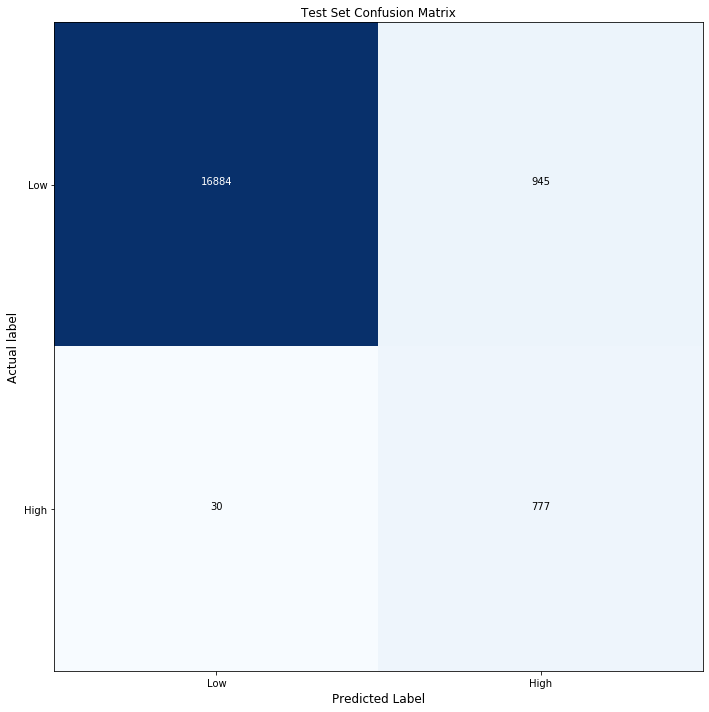

In [46]:
show cnfM:.ml.confmat[ytest;pred1]
conf:.ml.confdict[ytest;pred1;1b]

acc:(count where pred1=ytest)%count[ytest]
meanclassavg:avg (conf[`tp]%(sum conf[`tp`fn]);conf[`tn]%(sum conf[`tn`fp]))

-1"The accuracy of the model is ",string acc;
-1"The mean_class_accuracy of the model is ",string meanclassavg;
.ml.displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]

### Neural Net

Import models needed for Neural Net

In [47]:
tf: .p.import[`tensorflow]
ker: .p.import[`tensorflow.keras]
layers:.p.import[`tensorflow.keras.layers]
dense:  .p.import[`keras.layers]`:Dense

km:.p.import[`keras_metrics]
models:.p.import[`keras]`:Model
sequential:.p.import[`keras.models]`:Sequential
plt:.p.import[`matplotlib]`:pyplot
inp:.p.import[`keras.layers]`:Input


Using TensorFlow backend.


In [48]:
inputl:inp[`shape pykw enlist 51]
hidden1:dense[40;`activation pykw `relu][inputl]
hidden2:dense[40;`activation pykw `relu][hidden1]
o:dense[1;`activation pykw `sigmoid][hidden2]

modl:models[`inputs pykw inputl;`outputs pykw o]
modl[`:compile][`optimizer pykw "adam";`loss pykw "binary_crossentropy";`metrics pykw (km[`:binary_precision][]`;km[`:binary_recall][]`)];
modl[`:summary][];

res:modl[`:fit][array[xtr];ytr;`batch_size pykw 100;`verbose pykw 1;`epochs pykw 100];



W0805 05:28:25.290357 139773060096000 deprecation_wrapper.py:119] From /home/dianeodonoghue/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 05:28:25.306104 139773060096000 deprecation_wrapper.py:119] From /home/dianeodonoghue/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 05:28:25.309896 139773060096000 deprecation_wrapper.py:119] From /home/dianeodonoghue/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 05:28:25.356362 139773060096000 deprecation_wrapper.py:119] From /home/dianeodonoghue/miniconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 51)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 3,761
Trainable params: 3,761
Non-trainable params: 0
_________________________________________________________________


2019-08-05 05:28:25.740573: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-08-05 05:28:25.754437: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-08-05 05:28:25.758214: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6f766a0 executing computations on platform Host. Devices:
2019-08-05 05:28:25.758347: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-08-05 05:28:25.760561: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-08-05 05:28:26.316421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-08-05 05:28:26.317433: I tensorflow/core/common_runtime/gpu/gp

Epoch 1/100
20522/20522 [==============================] - ETA: 0s - loss: 0.2365 - precision: 0.8750 - recall: 0.32 - ETA: 0s - loss: 0.2127 - precision: 0.8991 - recall: 0.40 - ETA: 0s - loss: 0.1921 - precision: 0.9019 - recall: 0.44 - ETA: 0s - loss: 0.1831 - precision: 0.9013 - recall: 0.45 - 1s 26us/step - loss: 0.1751 - precision: 0.9096 - recall: 0.4695
Epoch 2/100
20522/20522 [==============================] - 0s 15us/step - loss: 0.1149 - precision: 0.9188 - recall: 0.6129 0s - loss: 0.1299 - precision: 0.9333 - recall: 0. - ETA: 0s - loss: 0.1185 - precision: 0.9292 - recall: 0.61 - ETA: 0s - loss: 0.1162 - precision: 0.9274 - recall: 0.61 - ETA: 0s - loss: 0.1180 - precision: 0.9192 - recall: 0.
Epoch 3/100
20522/20522 [==============================] - ETA: 0s - loss: 0.1062 - precision: 0.9217 - recall: 0.6318 ETA: 0s - loss: 0.1060 - precision: 0.9214 - recall: 0.65 - ETA: 0s - loss: 0.1079 - precision: 0.9226 - recall: 0.63 - ETA: 0s - loss: 0.1071 - precision: 0.9215 -

20522/20522 [==============================] - 0s 13us/step - loss: 0.0654 - precision: 0.9397 - recall: 0.7719 0s - loss: 0.0645 - precision: 0.9478 - recall - ETA: 0s - loss: 0.0657 - precision: 0.9410 - recall: 0.76
Epoch 26/100
20522/20522 [==============================] - ETA: 0s - loss: 0.0642 - precision: 0.9460 - recall: 0.7816 ETA: 0s - loss: 0.0650 - precision: 0.9580 - recall: 0. - ETA: 0s - loss: 0.0660 - precision: 0.9367 - recall: 0.77 - ETA: 0s - loss: 0.0644 - precision: 0.9376 - recall: 0.77 - ETA: 0s - loss: 0.0640 - precision: 0.9390 - recall: 0.77 - 0s 13us/step - loss: 0.0647 - precision: 0.9388 - recall: 0.7776
Epoch 27/100
20522/20522 [==============================] - ETA: 0s - loss: 0.0633 - precision: 0.9368 - recall: 0.7933 ETA: 0s - loss: 0.0622 - precision: 0.9421 - recall: 0.82 - ETA: 0s - loss: 0.0629 - precision: 0.9394 - recall - 0s 14us/step - loss: 0.0629 - precision: 0.9348 - recall: 0.7932
Epoch 28/100
20522/20522 [==============================] -

20522/20522 [==============================] - ETA: 0s - loss: 0.0484 - precision: 0.9511 - recall: 0.8396 ETA: 0s - loss: 0.0476 - precision: 0.9477 - recall: 0.84 - ETA: 0s - loss: 0.0465 - precision: 0.9539 - recall: 0.84 - ETA: 0s - loss: 0.0470 - precision: 0.9484 - recall: 0.84 - ETA: 0s - loss: 0.0476 - precision: 0.9510 - recall: 0. - 0s 14us/step - loss: 0.0482 - precision: 0.9474 - recall: 0.8404
Epoch 47/100
20522/20522 [==============================] - ETA: 0s - loss: 0.0478 - precision: 0.9476 - recall: 0.8497 ETA: 0s - loss: 0.0548 - precision: 0.9341 - recall: 0.82 - ETA: 0s - loss: 0.0507 - precision: 0.9431 - recall: 0. - ETA: 0s - loss: 0.0488 - precision: 0.9430 - recall: 0.84 - ETA: 0s - loss: 0.0485 - precision: 0.9421 - recall: 0.84 - 0s 13us/step - loss: 0.0480 - precision: 0.9414 - recall: 0.8427
Epoch 48/100
20522/20522 [==============================] - 0s 13us/step - loss: 0.0471 - precision: 0.9432 - recall: 0.8422 0s - loss: 0.0409 - precision: 0.9562 - re

20522/20522 [==============================] - 0s 14us/step - loss: 0.0367 - precision: 0.9581 - recall: 0.8825 0s - loss: 0.0328 - precision: 0.9709 - recall: 0.89 - ETA: 0s - loss: 0.0356 - precision: 0.9648 - recall: 0.89 - ETA: 0s - loss: 0.0362 - precision: 0.9556 - recall: 0.88
Epoch 69/100
20522/20522 [==============================] - ETA: 0s - loss: 0.0364 - precision: 0.9487 - recall: 0.8855 ETA: 0s - loss: 0.0338 - precision: 0.9515 - recall: 0.91 - ETA: 0s - loss: 0.0351 - precision: 0.9488 - recall: 0.89 - ETA: 0s - loss: 0.0354 - precision: 0.9573 - recall: 0. - ETA: 0s - loss: 0.0367 - precision: 0.9469 - recall: 0.88 - 0s 14us/step - loss: 0.0367 - precision: 0.9481 - recall: 0.8842
Epoch 70/100
20522/20522 [==============================] - 0s 14us/step - loss: 0.0352 - precision: 0.9543 - recall: 0.8785 0s - loss: 0.0326 - precision: 0.9639 - recall: 0.87 - ETA: 0s - loss: 0.0351 - precision: 0.9544 - recall: 0.87 - ETA: 0s - loss: 0.0348 - precision: 0.9540 - recall:

20522/20522 [==============================] - ETA: 0s - loss: 0.0264 - precision: 0.9643 - recall: 0.9161 ETA: 0s - loss: 0.0255 - precision: 0.9683 - recall: 0. - 0s 14us/step - loss: 0.0276 - precision: 0.9648 - recall: 0.9159
Epoch 92/100
20522/20522 [==============================] - 0s 14us/step - loss: 0.0264 - precision: 0.9696 - recall: 0.9188 0s - loss: 0.0284 - precision: 0.9598 - recall: 0.91 - ETA: 0s - loss: 0.0259 - precision: 0.9615 - recall: 0.92 - ETA: 0s - loss: 0.0263 - precision: 0.9644 - recall: 
Epoch 93/100
20522/20522 [==============================] - 0s 14us/step - loss: 0.0270 - precision: 0.9655 - recall: 0.9199 0s - loss: 0.0228 - precision: 0.9637 - recall: 0. - ETA: 0s - loss: 0.0268 - precision: 0.9646 - recall: 0.92 - ETA: 0s - loss: 0.0261 - precision: 0.9680 - recall: 0.
Epoch 94/100
20522/20522 [==============================] - ETA: 0s - loss: 0.0060 - precision: 1.0000 - recall: 1.00 - ETA: 0s - loss: 0.0225 - precision: 0.9765 - recall: 0.91 - ET

In [49]:
show nnPred:raze(modl[`:predict]array[mattab xtest])`

0.0001483858 1.490116e-07 0.005833924 0.0002307594 0.01736081 2.086163e-07 0...


loss     | 0.1750883 0.1148755 0.1061981 0.1011553 0.09711752 0.09459616 0.09..
precision| 0.9095982 0.9188256 0.9221106 0.9227609 0.9315403  0.9238095  0.92..
recall   | 0.46947   0.6129032 0.6342166 0.6468894 0.6584101  0.6705069  0.67..
loss     | 0.1750883 0.1148755 0.1061981 0.1011553 0.09711752 0.09459616 0.09..
precision| 0.9095982 0.9188256 0.9221106 0.9227609 0.9315403  0.9238095  0.92..
recall   | 0.46947   0.6129032 0.6342166 0.6468894 0.6584101  0.6705069  0.67..


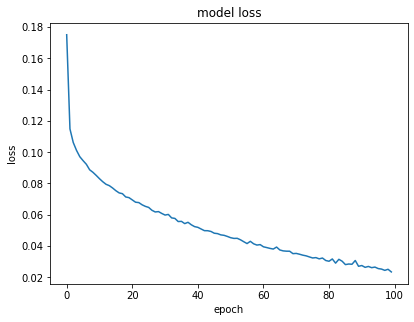

The accuracy of the model is 0.8990127
The mean_class_accuracy of the model is 0.7110373


In [56]:
show hist:6#(res[`:history]`)

plt[`:plot]hist`loss;
plt[`:plot]hist`val_loss;
plt[`:title]"model loss";
plt[`:ylabel]"loss";
plt[`:xlabel]"epoch";
plt[`:show][];

conf:.ml.confdict[ytest;0.5<nnPred;1b]


acc:(count where (0.5<nnPred)=ytest)%count[ytest]
meanclassavg:avg (conf[`tp]%(sum conf[`tp`fn]);conf[`tn]%(sum conf[`tn`fp]))
-1"The accuracy of the model is ",string acc;
-1"The mean_class_accuracy of the model is ",string meanclassavg;

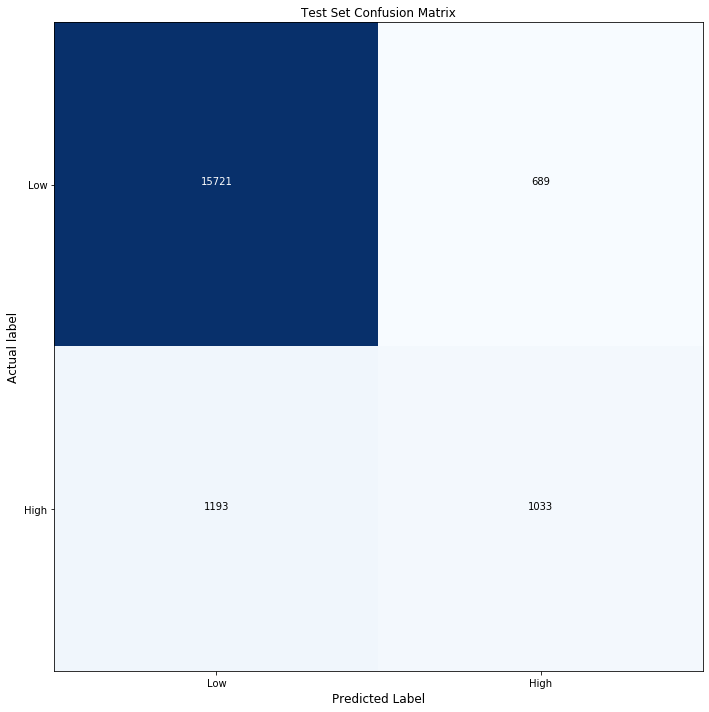

In [55]:
cnfM:.ml.confmat[ytest;0.5<nnPred]
.ml.displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]